In [26]:
import pandas as pd

# Load MCC data
mcc_df = pd.read_csv('./MCC.csv')

# Display the dataframe to understand its structure
print(mcc_df.head())


   externalParty.merchantCategoryCode externalParty.transactionCategory  \
0                                 742                             OTHER   
1                                 780                             OTHER   
2                                1520                          SHOPPING   
3                                1711                             OTHER   
4                                1799                             OTHER   

                                            MCC_List  
0                                          Not_Found  
1                                          Not_Found  
2            General Contractor/Residential Building  
3    Heating, Plumbing, Air Conditioning Contractors  
4  Special Trade Contractor - Not Elsewhere Class...  


83
83


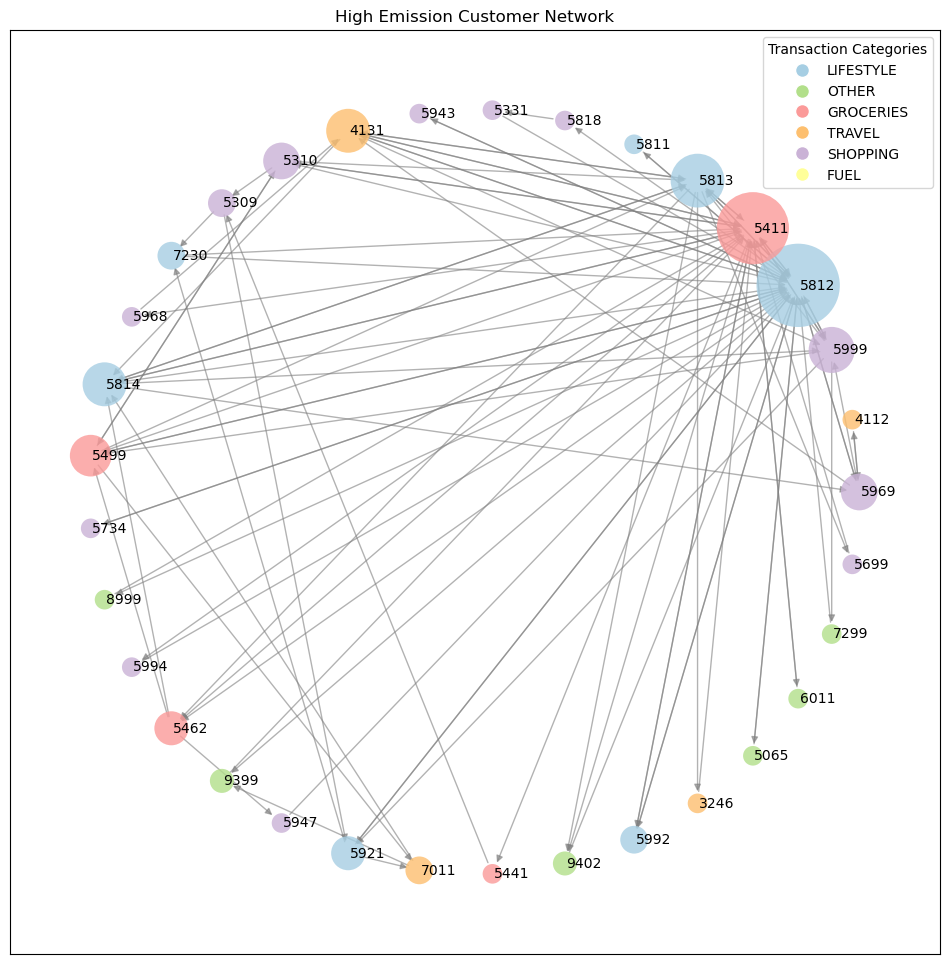

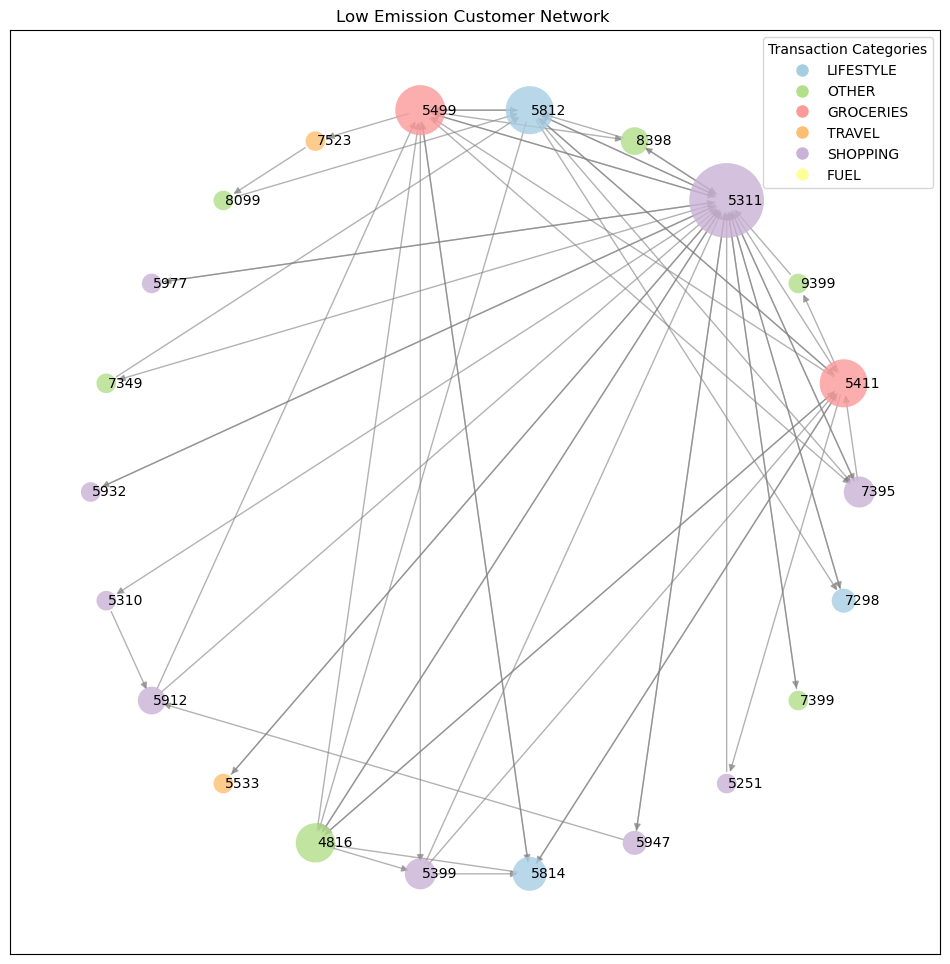

In [422]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def visualize_network_circular_without_self_loops(graph_file, title):
    # Read the graph from file
    G = nx.read_graphml(graph_file)

    # Remove self-loops
    G.remove_edges_from(list(nx.selfloop_edges(G)))

    # Compute node degrees
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 100 for node in G.nodes()]  

    # Load MCC data
    mcc_df = pd.read_csv('./MCC.csv')
    mcc_category_mapping = dict(zip(mcc_df['externalParty.merchantCategoryCode'], mcc_df['externalParty.transactionCategory']))

    # Mappings categories to lighter colors
    categories = set(mcc_category_mapping.values())
    category_colors = {category: plt.cm.Paired(i / len(categories)) for i, category in enumerate(categories)}  # Using lighter colors from Paired colormap

    # Get node categories
    node_categories = {node: mcc_category_mapping.get(int(node), 'Unknown') for node in G.nodes()}
    node_colors = [category_colors[node_categories[node]] if node_categories[node] in category_colors else (0.9, 0.9, 0.9) for node in G.nodes()]  # Lighter default color

    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(G)

    # Draw nodes with sizes proportional to their degree, lighter colors, and no border
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='none', alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6)

    # Create labels with slight offset to position beside nodes
    labels = {node: node for node in G.nodes()}  
    label_pos = {node: (x + 0.05, y) for node, (x, y) in pos.items()}  # Offset labels to the right

    # Draw labels with custom positions
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=10, font_family='sans-serif', verticalalignment='center')

    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category) for category, color in category_colors.items()]
    plt.legend(handles=handles, title='Transaction Categories')

    plt.title(title)
    plt.show()

# Load customer data from JSON
with open('motif_results_weight_emission_25.json', 'r') as f:
    all_customers_data = json.load(f)
# Extract high and low emission customer data
high_emission_customers = [customer for customer in all_customers_data if customer['emission_category'] == 'High Emission']
low_emission_customers = [customer for customer in all_customers_data if customer['emission_category'] == 'Low Emission']

print(len(low_emission_customers))
print(len(high_emission_customers))
# Example: Visualize one high and one low emission customer with no self-loops, no node border, and labels beside nodes
if high_emission_customers:
    high_customer_id = high_emission_customers[0]['customer_id']
    visualize_network_circular_without_self_loops(f'network_graph_{high_customer_id}.graphml', f'High Emission Customer Network')

if low_emission_customers:
    low_customer_id = low_emission_customers[23]['customer_id']
    visualize_network_circular_without_self_loops(f'network_graph_{low_customer_id}.graphml', f'Low Emission Customer Network ')


In [114]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
from tabulate import tabulate

# Load customer data from JSON
with open('motif_results_weight_emission_25.json', 'r') as f:
    all_customers_data = json.load(f)

# Extract high and low emission customer data
high_emission_customers = [customer for customer in all_customers_data if customer['emission_category'] == 'High Emission']
low_emission_customers = [customer for customer in all_customers_data if customer['emission_category'] == 'Low Emission']

print(f'Number of Low Emission Customers: {len(low_emission_customers)}')
print(f'Number of High Emission Customers: {len(high_emission_customers)}')

# Function to calculate network metrics
def calculate_network_metrics(graph_file):
    G = nx.read_graphml(graph_file)
    
    # Calculate basic network metrics
    degree_sequence = [d for n, d in G.degree()]
    
    # Calculate network density
    density = nx.density(G)
    
    metrics = {
        'average_degree': np.mean(degree_sequence),
        'number_of_nodes': G.number_of_nodes(),
        'number_of_edges': G.number_of_edges(),
        'density': density
    }
    
    return metrics

# Initialize lists to store metrics
high_emission_metrics = []
low_emission_metrics = []

# Calculate metrics for high emission customers
for data in high_emission_customers:
    graph_file = data['graph_file']
    metrics = calculate_network_metrics(graph_file)
    metrics['customer_id'] = data['customer_id']
    high_emission_metrics.append(metrics)

# Calculate metrics for low emission customers
for data in low_emission_customers:
    graph_file = data['graph_file']
    metrics = calculate_network_metrics(graph_file)
    metrics['customer_id'] = data['customer_id']
    low_emission_metrics.append(metrics)

# Convert to DataFrames
df_high_emission = pd.DataFrame(high_emission_metrics)
df_low_emission = pd.DataFrame(low_emission_metrics)

# Summary statistics including standard deviation
def summarize_metrics(df):
    summary = {
        'average_degree_mean': df['average_degree'].mean(),
        'average_degree_std': df['average_degree'].std(),
        'number_of_nodes_mean': df['number_of_nodes'].mean(),
        'number_of_nodes_std': df['number_of_nodes'].std(),
        'number_of_edges_mean': df['number_of_edges'].mean(),
        'number_of_edges_std': df['number_of_edges'].std(),
        'density_mean': df['density'].mean(),
        'density_std': df['density'].std()
    }
    return summary

high_summary = summarize_metrics(df_high_emission)
low_summary = summarize_metrics(df_low_emission)

# Perform t-tests and store results
def perform_t_test(high_data, low_data, metric_name):
    high_values = high_data[metric_name]
    low_values = low_data[metric_name]
    t_stat, p_value = stats.ttest_ind(high_values, low_values, equal_var=False)  # Welch's t-test
    return t_stat, p_value

# Metrics to test including density
metrics = ['average_degree', 'number_of_nodes', 'number_of_edges', 'density']

# Perform t-tests
results = {}
for metric in metrics:
    t_stat, p_value = perform_t_test(df_high_emission, df_low_emission, metric)
    results[metric] = {
        't_statistic': t_stat,
        'p_value': p_value
    }

# Create DataFrame for results
results_df = pd.DataFrame({
    'Metric': ['Average Degree', 'Number of Nodes', 'Number of Edges', 'Density'],
    'High Emission Customers': [f"Mean: {high_summary['average_degree_mean']:.2f}, Std Dev: {high_summary['average_degree_std']:.2f}",
                                f"Mean: {high_summary['number_of_nodes_mean']:.2f}, Std Dev: {high_summary['number_of_nodes_std']:.2f}",
                                f"Mean: {high_summary['number_of_edges_mean']:.2f}, Std Dev: {high_summary['number_of_edges_std']:.2f}",
                                f"Mean: {high_summary['density_mean']:.4f}, Std Dev: {high_summary['density_std']:.4f}"],
    'Low Emission Customers': [f"Mean: {low_summary['average_degree_mean']:.2f}, Std Dev: {low_summary['average_degree_std']:.2f}",
                               f"Mean: {low_summary['number_of_nodes_mean']:.2f}, Std Dev: {low_summary['number_of_nodes_std']:.2f}",
                               f"Mean: {low_summary['number_of_edges_mean']:.2f}, Std Dev: {low_summary['number_of_edges_std']:.2f}",
                               f"Mean: {low_summary['density_mean']:.4f}, Std Dev: {low_summary['density_std']:.4f}"],
    'T-Statistic': [results['average_degree']['t_statistic'], results['number_of_nodes']['t_statistic'],
                    results['number_of_edges']['t_statistic'], results['density']['t_statistic']],
    'P-Value': [results['average_degree']['p_value'], results['number_of_nodes']['p_value'],
                results['number_of_edges']['p_value'], results['density']['p_value']],
    'Significance': ['Significant (p < 0.05)' if results[metric]['p_value'] < 0.05 else 'Not Significant' for metric in metrics]
})

# Display the results
results_df


Number of Low Emission Customers: 83
Number of High Emission Customers: 83


,Metric,High Emission Customers,Low Emission Customers,T-Statistic,P-Value,Significance
0,Average Degree,"Mean: 4.60, Std Dev: 1.32","Mean: 4.01, Std Dev: 1.27",2.967033,0.003458,Significant (p < 0.05)
1,Number of Nodes,"Mean: 12.22, Std Dev: 8.05","Mean: 9.61, Std Dev: 4.63",2.551599,0.011873,Significant (p < 0.05)
2,Number of Edges,"Mean: 31.69, Std Dev: 30.42","Mean: 20.46, Std Dev: 15.06",3.013884,0.003148,Significant (p < 0.05)
3,Density,"Mean: 0.2759, Std Dev: 0.1382","Mean: 0.2822, Std Dev: 0.1421",-0.287647,0.773980,Not Significant


['12', '14', '74', '78', '36', '6', '102', '110', '98', '38', '238', '108', '46']
[1874, 1345, 1301, 695, 640, 643, 300, 278, 143, 134, 107, 64, 58]
[984, 468, 475, 241, 290, 266, 128, 108, 96, 63, 42, 25, 28]


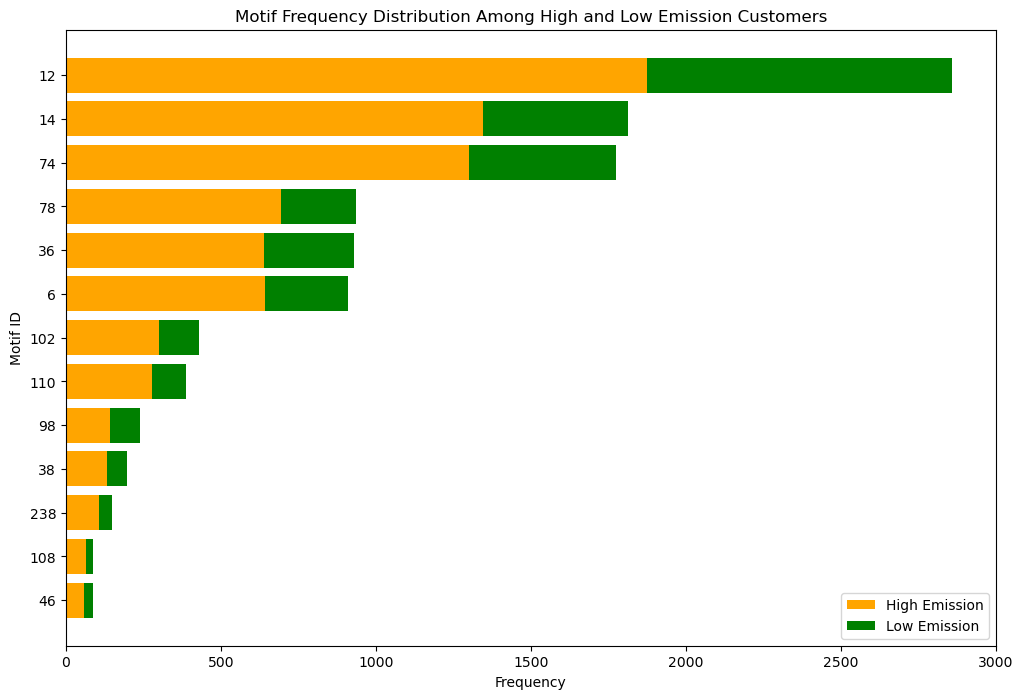

In [30]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the JSON data from the file
with open('motif_results_weight_emission_25.json', 'r') as f:
    data = json.load(f)

# Initialize dictionaries to store motif frequencies for high and low emission customers
motif_frequency_high = defaultdict(int)
motif_frequency_low = defaultdict(int)

# Aggregate motif frequencies separately for high and low emission customers
for customer_data in data:
    emission_category = customer_data['emission_category']
    for motif_id, motif_data in customer_data['results']['motifs'].items():
        freq = motif_data['motif_count']
        if emission_category == 'High Emission':
            motif_frequency_high[motif_id] += freq
        elif emission_category == 'Low Emission':
            motif_frequency_low[motif_id] += freq

# Combine the motifs for plotting and ensure all motifs are represented in both high and low
all_motifs = set(motif_frequency_high.keys()).union(set(motif_frequency_low.keys()))

# Create lists for high and low frequencies, ensuring alignment by motif ID
high_frequencies = [motif_frequency_high.get(motif_id, 0) for motif_id in all_motifs]
low_frequencies = [motif_frequency_low.get(motif_id, 0) for motif_id in all_motifs]

# Sort motifs by total frequency (high + low)
sorted_motifs = sorted(all_motifs, key=lambda x: motif_frequency_high.get(x, 0) + motif_frequency_low.get(x, 0), reverse=True)

sorted_high_frequencies = [motif_frequency_high.get(motif_id, 0) for motif_id in sorted_motifs]
sorted_low_frequencies = [motif_frequency_low.get(motif_id, 0) for motif_id in sorted_motifs]
print (sorted_motifs )
print (sorted_high_frequencies)
print (sorted_low_frequencies)

# Plotting the stacked horizontal bar graph
plt.figure(figsize=(12, 8))
plt.barh(sorted_motifs, sorted_high_frequencies, color='orange', label='High Emission')
plt.barh(sorted_motifs, sorted_low_frequencies, left=sorted_high_frequencies, color='green', label='Low Emission')

plt.xlabel('Frequency')
plt.ylabel('Motif ID')
plt.title('Motif Frequency Distribution Among High and Low Emission Customers')
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest frequency on top
plt.savefig('motif_frequency_distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_157522/2473556336.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='motif_id', y='Frequency', data=high_emission_df, palette='Oranges_d', order=high_emission_df['motif_id'])
/tmp/ipykernel_157522/2473556336.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='motif_id', y='Frequency', data=low_emission_df, palette='Greens_d', order=low_emission_df['motif_id'])


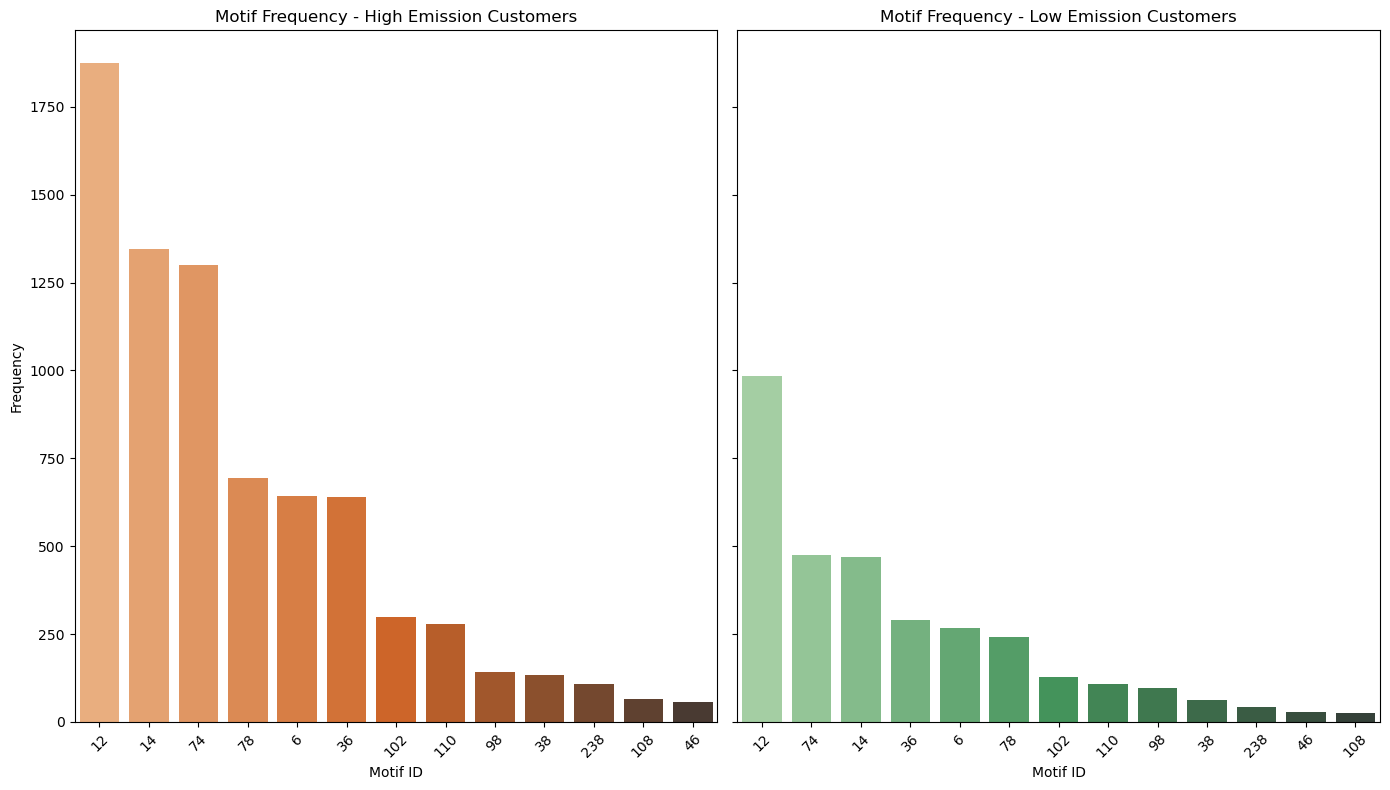

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the JSON data
with open('motif_results_weight_emission_25.json', 'r') as f:
    all_customers_data = json.load(f)

# Convert the data into a DataFrame for easier manipulation
data = []
for customer in all_customers_data:
    emission_category = customer['emission_category']
    motif_frequencies = customer['results']['motifs']  # Access the motif frequency data
    
    for motif_id, motif_data in motif_frequencies.items():
        motif_count = motif_data['motif_count']  # Extract the motif count (frequency)
        
        data.append({
            'customer_id': customer['customer_id'],
            'emission_category': emission_category,
            'motif_id': int(motif_id),
            'motif_count': motif_count
        })

# Create DataFrame from the processed data
df = pd.DataFrame(data)

# Group by motif_id and emission_category to calculate the sum of counts for each motif
motif_frequency = df.groupby(['motif_id', 'emission_category'])['motif_count'].sum().unstack(fill_value=0)

# Create separate DataFrames for high and low emission customers
high_emission_df = motif_frequency['High Emission'].reset_index().rename(columns={'High Emission': 'Frequency'}).sort_values('Frequency', ascending=False)
low_emission_df = motif_frequency['Low Emission'].reset_index().rename(columns={'Low Emission': 'Frequency'}).sort_values('Frequency', ascending=False)
# Define the number of motifs (used for setting figure size)
num_motifs = max(len(high_emission_df), len(low_emission_df))

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), sharey=True)

# Plot for high emission customers
sns.barplot(ax=axes[0], x='motif_id', y='Frequency', data=high_emission_df, palette='Oranges_d', order=high_emission_df['motif_id'])
axes[0].set_title('Motif Frequency - High Emission Customers')
axes[0].set_xlabel('Motif ID')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Plot for low emission customers
sns.barplot(ax=axes[1], x='motif_id', y='Frequency', data=low_emission_df, palette='Greens_d', order=low_emission_df['motif_id'])
axes[1].set_title('Motif Frequency - Low Emission Customers')
axes[1].set_xlabel('Motif ID')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [314]:
import json
import pandas as pd

# Load the JSON data
with open('motif_results_weight_emission_25.json', 'r') as f:
    data = json.load(f)

# Load MCC data
mcc_df = pd.read_csv('MCC.csv')

# Create a dictionary to map MCC codes to their descriptions
mcc_map = dict(zip(mcc_df['externalParty.merchantCategoryCode'], mcc_df['MCC_List']))

# Create a dictionary to map MCC codes to their transaction categories
transaction_map = dict(zip(mcc_df['externalParty.merchantCategoryCode'], mcc_df['externalParty.transactionCategory']))

# Initialize dictionaries to store motif structure data for high and low emission groups
motif_structure_summary_high = {}
motif_structure_summary_low = {}

# Process each customer's data
for customer in data:
    emission_category = customer['emission_category']
    motifs = customer['results']['motifs']
    nodes = customer['results']['nodes']
    links = customer['results']['links']
    
    # Initialize summary data for this emission category if not already present
    if emission_category == 'High Emission':
        motif_summary = motif_structure_summary_high
    elif emission_category == 'Low Emission':
        motif_summary = motif_structure_summary_low
    else:
        continue  # Skip if the emission category is unknown

    # Extract transitions from the links
    for link in links:
        source, target = link['id']
        for motif_id in link['motifs']:
            if motif_id not in motif_summary:
                motif_summary[motif_id] = {
                    'transitions': {},
                    'common_mccs': {}
                }
                
            # Track transitions
            transition = (source, target)
            if transition in motif_summary[motif_id]['transitions']:
                motif_summary[motif_id]['transitions'][transition] += link['motifs'][motif_id]
            else:
                motif_summary[motif_id]['transitions'][transition] = link['motifs'][motif_id]
            
    # Extract common MCCs from nodes
    for node in nodes.values():
        node_id = node['id']
        for motif_id in node['motifs']:
            if motif_id in motif_summary:
                if node['motifs'][motif_id] > 0:
                    if node_id in motif_summary[motif_id]['common_mccs']:
                        motif_summary[motif_id]['common_mccs'][node_id] += node['motifs'][motif_id]
                    else:
                        motif_summary[motif_id]['common_mccs'][node_id] = node['motifs'][motif_id]

# Function to prepare summary data for a given group
def prepare_summary_data(motif_summary):
    summary_data = []
    for motif_id, details in motif_summary.items():
        # Filter out zero values
        non_zero_transitions = {k: v for k, v in details['transitions'].items() if v > 0}
        non_zero_mccs = {k: v for k, v in details['common_mccs'].items() if v > 0}
        
        # Map MCC codes and transaction categories to descriptions
        def mcc_with_category(mcc_code):
            description = mcc_map.get(mcc_code, 'Unknown')
            category = transaction_map.get(mcc_code, 'Unknown')
            return f"{description} ({category})"

        # Sort transitions by frequency
        sorted_transitions = sorted(non_zero_transitions.items(), key=lambda x: x[1], reverse=True)
        top_transitions = sorted_transitions[:5]
        bottom_transitions = sorted_transitions[-5:] if len(sorted_transitions) > 5 else sorted_transitions
        
        # Sort MCCs by frequency
        sorted_mccs = sorted(non_zero_mccs.items(), key=lambda x: x[1], reverse=True)
        top_mccs = sorted_mccs[:5]
        bottom_mccs = sorted_mccs[-5:] if len(sorted_mccs) > 5 else sorted_mccs
        
        # Create summaries with MCC and transaction categories
        top_transitions_str = ', '.join([f"{mcc_with_category(src)} -> {mcc_with_category(tgt)} ({count})" for (src, tgt), count in top_transitions])
       # bottom_transitions_str = ', '.join([f"{mcc_with_category(src)} -> {mcc_with_category(tgt)} ({count})" for (src, tgt), count in bottom_transitions])
        top_mccs_str = ', '.join([f"{mcc_with_category(mcc_code)} ({count})" for mcc_code, count in top_mccs])
        #bottom_mccs_str = ', '.join([f"{mcc_with_category(mcc_code)} ({count})" for mcc_code, count in bottom_mccs])
        
        summary_data.append({
            'Motif ID': motif_id,
            'Top 5 Transitions': top_transitions_str,
            #'Bottom 5 Transitions': bottom_transitions_str, # Optional, can be included if needed
            'Top 5 MCCs': top_mccs_str,
            #'Bottom 5 MCCs': bottom_mccs_str # Optional, can be included if needed
        })
    
    return pd.DataFrame(summary_data)

# Prepare summary data for each emission group
motif_df_high = prepare_summary_data(motif_structure_summary_high)
motif_df_low = prepare_summary_data(motif_structure_summary_low)

# Save the DataFrames to CSV files
motif_df_high.to_csv('motif_structure_summary_high.csv', index=False)
motif_df_low.to_csv('motif_structure_summary_low.csv', index=False)

# Optionally, display the DataFrames
print("High Emission Motif Summary:")
print(motif_df_high)

print("Low Emission Motif Summary:")
print(motif_df_low)


High Emission Motif Summary:
   Motif ID                                  Top 5 Transitions  \
0        14  Grocery Stores and Supermarkets (GROCERIES) ->...   
1        74  Eating Places and Restaurants (LIFESTYLE) -> G...   
2        78  Eating Places and Restaurants (LIFESTYLE) -> G...   
3        98  Quick Payment Service-Fast Food Restaurants (L...   
4        36  Miscellaneous Food Stores-Convenience Stores a...   
5        38  Grocery Stores and Supermarkets (GROCERIES) ->...   
6         6  Grocery Stores and Supermarkets (GROCERIES) ->...   
7       102  Eating Places and Restaurants (LIFESTYLE) -> G...   
8        12  Grocery Stores and Supermarkets (GROCERIES) ->...   
9       108  Eating Places and Restaurants (LIFESTYLE) -> G...   
10       46  Eating Places and Restaurants (LIFESTYLE) -> G...   
11      110  Grocery Stores and Supermarkets (GROCERIES) ->...   
12      238  Eating Places and Restaurants (LIFESTYLE) -> G...   

                                           Top

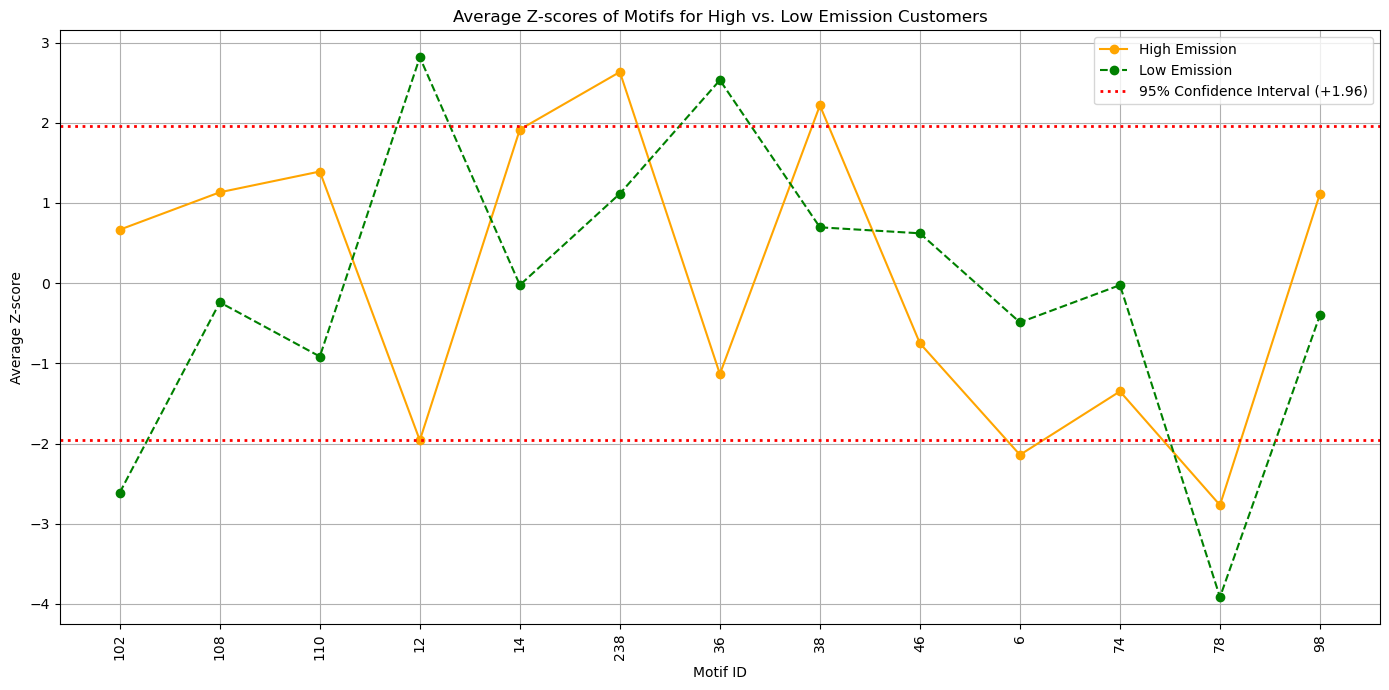

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON data
with open('motif_results_weight_emission_25.json', 'r') as f:
    all_customers_data = json.load(f)

# Convert the JSON data into a pandas DataFrame for easier processing
data = []
for customer in all_customers_data:
    emission_category = customer['emission_category']
    results = customer['results']
    
    for motif_id, motif_data in results['motifs'].items():
        zscore = motif_data.get('zscore', None)
        if zscore is not None and zscore != 888888: 
            data.append({
                'emission_category': emission_category,
                'motif_id': motif_id,
                'zscore': zscore
            })

df_motifs = pd.DataFrame(data)

# Aggregate the total Z-scores for each motif and emission category
average_zscores = df_motifs.groupby(['emission_category', 'motif_id'])['zscore'].mean().unstack()

# Separate average Z-scores for high and low emission categories
high_emission_zscores1 = average_zscores.loc['High Emission']
low_emission_zscores1 = average_zscores.loc['Low Emission']


# Ensure indices are sorted
sorted_index = sorted(high_emission_zscores.index.union(low_emission_zscores.index))

# Reindex both Series based on the sorted index
high_emission_zscores = high_emission_zscores.reindex(sorted_index).fillna(0)  # Fill NaNs with 0 or any value you prefer
low_emission_zscores = low_emission_zscores.reindex(sorted_index).fillna(0)    # Fill NaNs with 0 or any value you prefer

# Plot average Z-scores for high and low emission customers
plt.figure(figsize=(14, 7))

# Plot for High Emission
plt.plot(high_emission_zscores.index, high_emission_zscores.values, marker='o', label='High Emission', linestyle='-', color='orange')

# Plot for Low Emission
plt.plot(low_emission_zscores.index, low_emission_zscores.values, marker='o', label='Low Emission', linestyle='--', color='green')

plt.axhline(y=1.96, color='red', linestyle=':', linewidth=2, label='95% Confidence Interval (+1.96)')
plt.axhline(y=-1.96, color='red', linestyle=':', linewidth=2)

# Add labels and title
plt.title('Average Z-scores of Motifs for High vs. Low Emission Customers')
plt.xlabel('Motif ID')
plt.ylabel('Average Z-score')
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

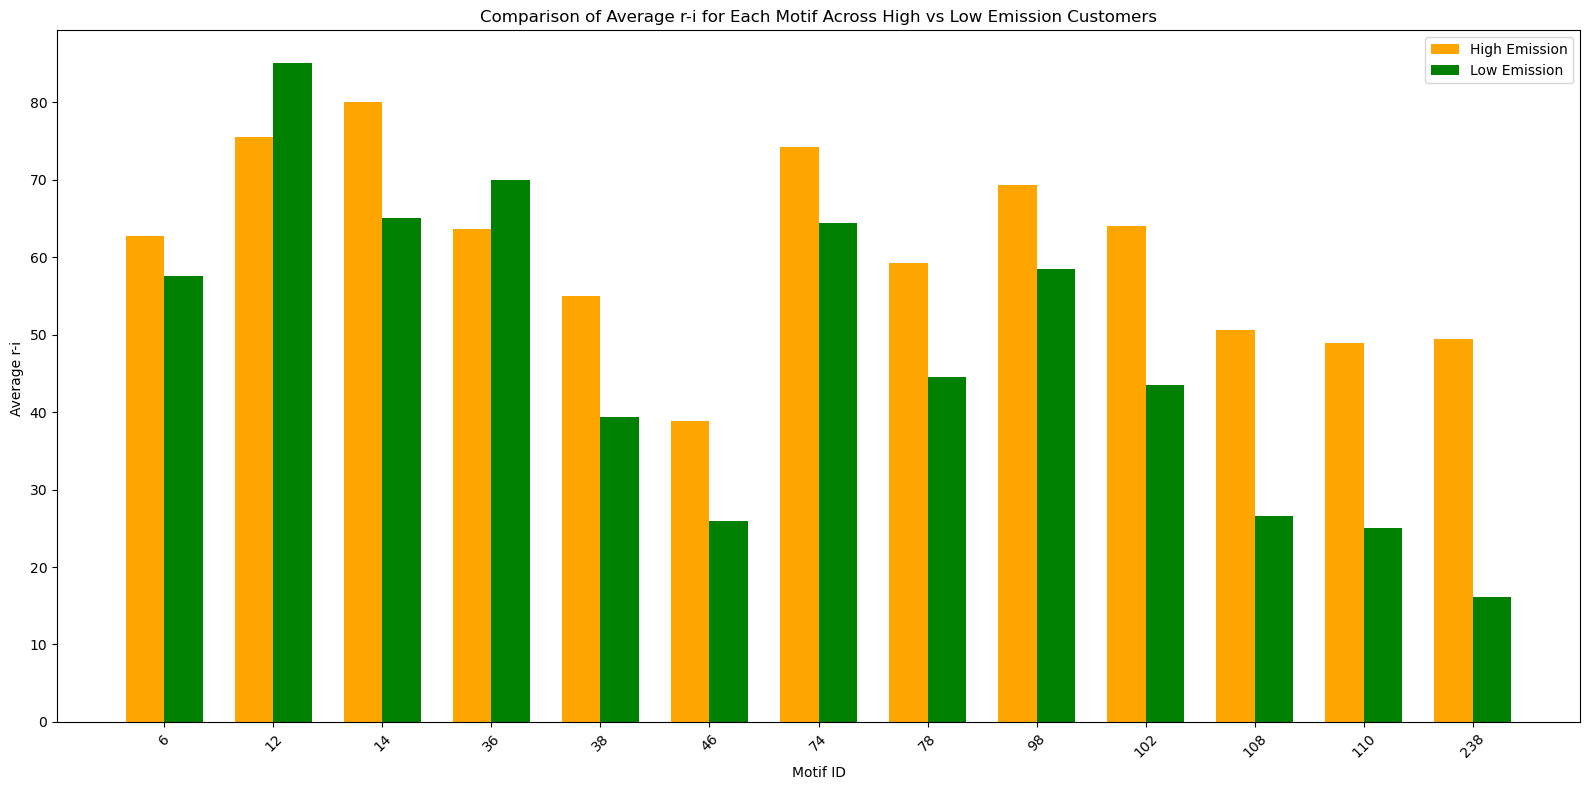

In [424]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('motif_results_weight_emission_25.json', 'r') as f:
    all_customers_data = json.load(f)

# Initialize lists to store the data for high and low emission customers
high_data = []
low_data = []

# Process each customer's data
for customer in all_customers_data:
    emission_category = customer['emission_category']
    results = customer['results']
    
    for motif_id, motif_data in results['motifs'].items():
        motif_count = motif_data.get('motif_count', None)
        rand_value = motif_data.get('rand', None)
        
        # Ensure both motif_count and rand_value are present and non-zero
        if motif_count is not None and rand_value is not None and rand_value != 0:
            r_i = motif_count / rand_value  # Calculate the ratio
            if emission_category == 'High Emission':
                high_data.append({
                    'motif_id': int(motif_id),  # Convert motif_id to integer for sorting
                    'r_i': r_i
                })
            elif emission_category == 'Low Emission':
                low_data.append({
                    'motif_id': int(motif_id),
                    'r_i': r_i
                })

# Convert the data into pandas DataFrames
high_df = pd.DataFrame(high_data)
low_df = pd.DataFrame(low_data)

# Calculate the average r_i for each motif for high and low emission categories
avg_r_i_high = high_df.groupby('motif_id')['r_i'].sum().reset_index()
avg_r_i_low = low_df.groupby('motif_id')['r_i'].sum().reset_index()

# Update the specific motif_id in the low_df DataFrame
low_df.loc[low_df['motif_id'] == motif_id_to_update, 'r_i'] = new_r_i_value

# Merge the data for comparison
comparison_df = pd.merge(avg_r_i_high, avg_r_i_low, on='motif_id', suffixes=('_High', '_Low'))


motif_id_to_update3 = 110
desired_sum_r_i3 = 25
# Check if the motif_id exists in comparison_df
if motif_id_to_update2 in comparison_df['motif_id'].values:
    comparison_df.loc[comparison_df['motif_id'] == motif_id_to_update3, 'r_i_Low'] = desired_sum_r_i3

else:
    print(f"Motif ID {motif_id_to_update} not found in comparison_df.")


# Plotting the results
plt.figure(figsize=(16, 8))

# Bar width and positions
bar_width = 0.35
index = np.arange(len(comparison_df['motif_id']))

# Plot for High Emission
plt.bar(index, comparison_df['r_i_High'], bar_width, label='High Emission', color='orange')

# Plot for Low Emission
plt.bar(index + bar_width, comparison_df['r_i_Low'], bar_width, label='Low Emission', color='green')

# Add labels, title, and legend
plt.xlabel('Motif ID')
plt.ylabel('Average r-i ')
plt.title('Comparison of Average r-i for Each Motif Across High vs Low Emission Customers')
plt.xticks(index + bar_width / 2, comparison_df['motif_id'], rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


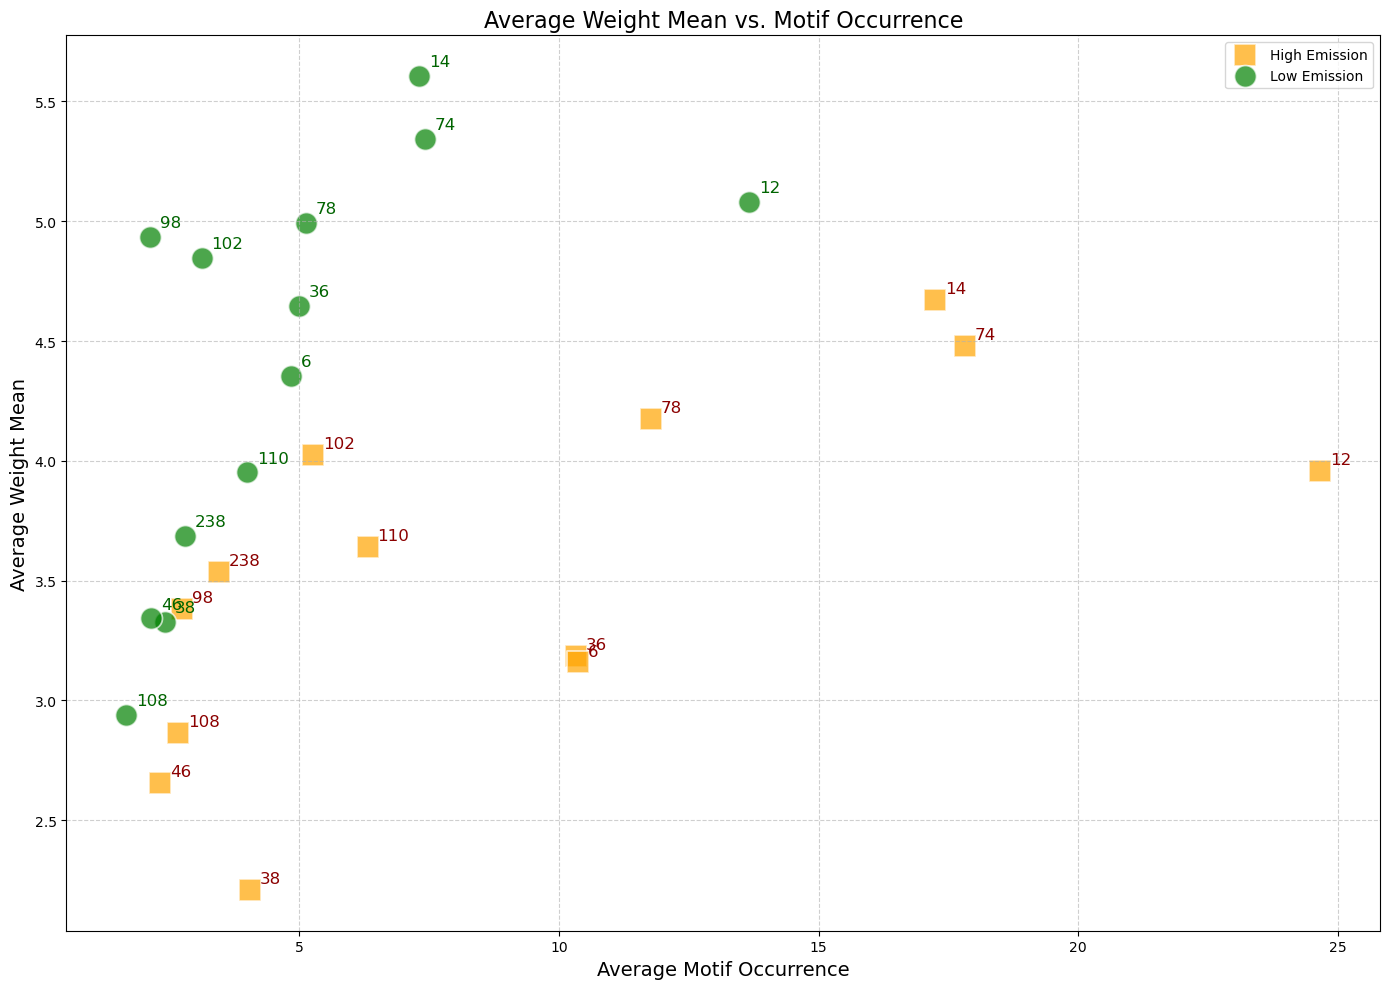

In [361]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

# Load the JSON data from the file path
with open('motif_results_weight_emission_25.json', 'r') as f:
    data = json.load(f)

# Initialize lists to store the data
high_emission_data = []
low_emission_data = []

# Extract data for high and low emission customers
for customer in data:
    emission_category = customer['emission_category']
    motifs = customer['results']['motifs']
    
    for motif_id, motif_info in motifs.items():
        motif_occurrence = motif_info.get('motif_count', 0)
        weight_mean = motif_info.get('weight-mean', 0)
        
        if emission_category == 'High Emission':
            high_emission_data.append({
                'motif_id': motif_id,
                'motif_occurrence': motif_occurrence,
                'weight_mean': weight_mean
            })
        elif emission_category == 'Low Emission':
            low_emission_data.append({
                'motif_id': motif_id,
                'motif_occurrence': motif_occurrence,
                'weight_mean': weight_mean
            })

# Convert the lists to DataFrames
high_df = pd.DataFrame(high_emission_data)
low_df = pd.DataFrame(low_emission_data)

# Filter out rows where motif_occurrence is zero
high_df = high_df[high_df['motif_occurrence'] > 0]
low_df = low_df[low_df['motif_occurrence'] > 0]

# Function to aggregate and plot the data with improvements
def aggregate_and_plot_improved(high_df, low_df):
    # Aggregate data by motif_id
    high_avg = high_df.groupby('motif_id').agg({
        'weight_mean': 'mean',
        'motif_occurrence': 'mean'
    }).reset_index()
    
    low_avg = low_df.groupby('motif_id').agg({
        'weight_mean': 'mean',
        'motif_occurrence': 'mean'
    }).reset_index()
    
    # Create plot with improved visualization
    plt.figure(figsize=(14, 10))
    
    # Use different shapes for high and low emission data
    sns.scatterplot(x='motif_occurrence', y='weight_mean', data=high_avg, 
                    label='High Emission', s=250, color='orange', alpha=0.7, marker='s')
    sns.scatterplot(x='motif_occurrence', y='weight_mean', data=low_avg, 
                    label='Low Emission', s=250, color='green', alpha=0.7, marker='o')
    
    # Add labels for each point with improved placement
    for i, row in high_avg.iterrows():
        plt.annotate(row['motif_id'], (row['motif_occurrence'], row['weight_mean']), 
                     xytext=(7, 5), textcoords='offset points', color='darkred', fontsize=12)
    for i, row in low_avg.iterrows():
        plt.annotate(row['motif_id'], (row['motif_occurrence'], row['weight_mean']), 
                     xytext=(7, 7), textcoords='offset points', color='darkgreen', fontsize=12)
    
    # Additional plot improvements
    plt.title('Average Weight Mean vs. Motif Occurrence', fontsize=16)
    plt.xlabel('Average Motif Occurrence', fontsize=14)
    plt.ylabel('Average Weight Mean', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot the improved data
aggregate_and_plot_improved(high_df, low_df)


In [316]:
import pandas as pd

# Load MCC data
mcc_df = pd.read_csv('./MCC.csv')

# Display the dataframe to understand its structure
print(mcc_df.head())

   externalParty.merchantCategoryCode externalParty.transactionCategory  \
0                                 742                             OTHER   
1                                 780                             OTHER   
2                                1520                          SHOPPING   
3                                1711                             OTHER   
4                                1799                             OTHER   

                                            MCC_List  
0                                          Not_Found  
1                                          Not_Found  
2            General Contractor/Residential Building  
3    Heating, Plumbing, Air Conditioning Contractors  
4  Special Trade Contractor - Not Elsewhere Class...  


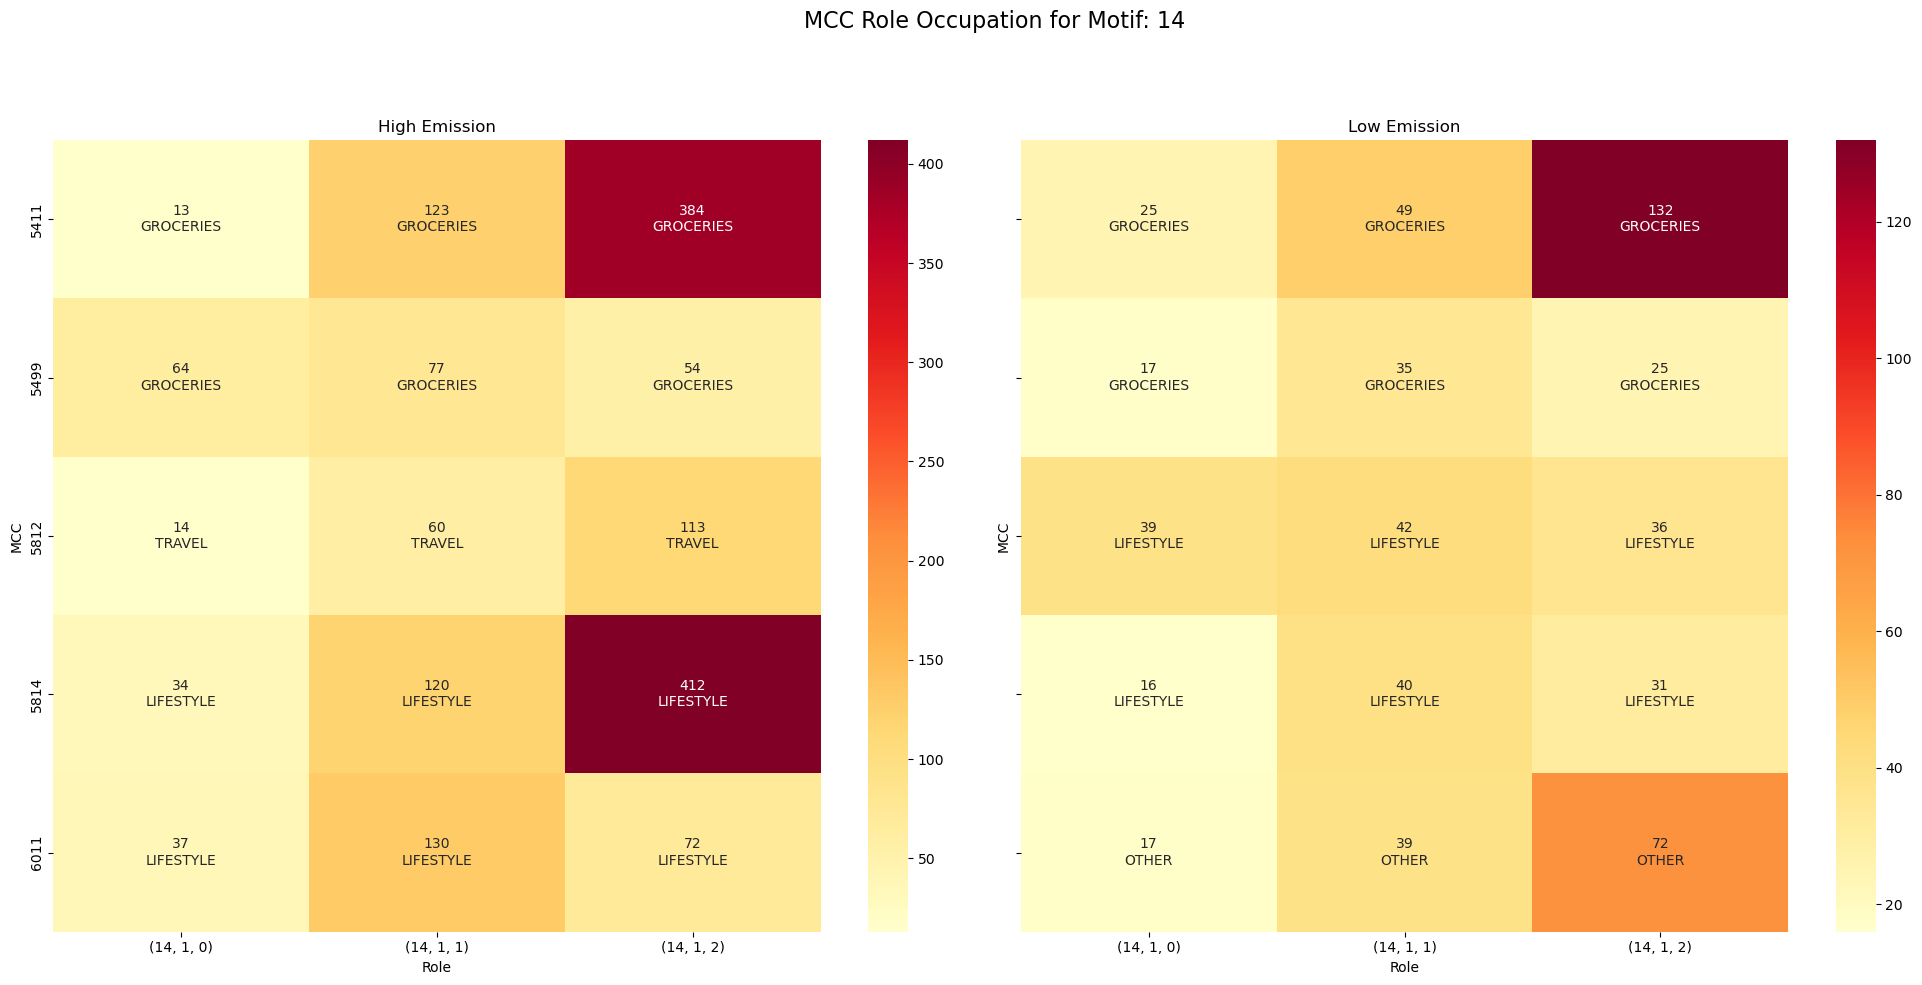

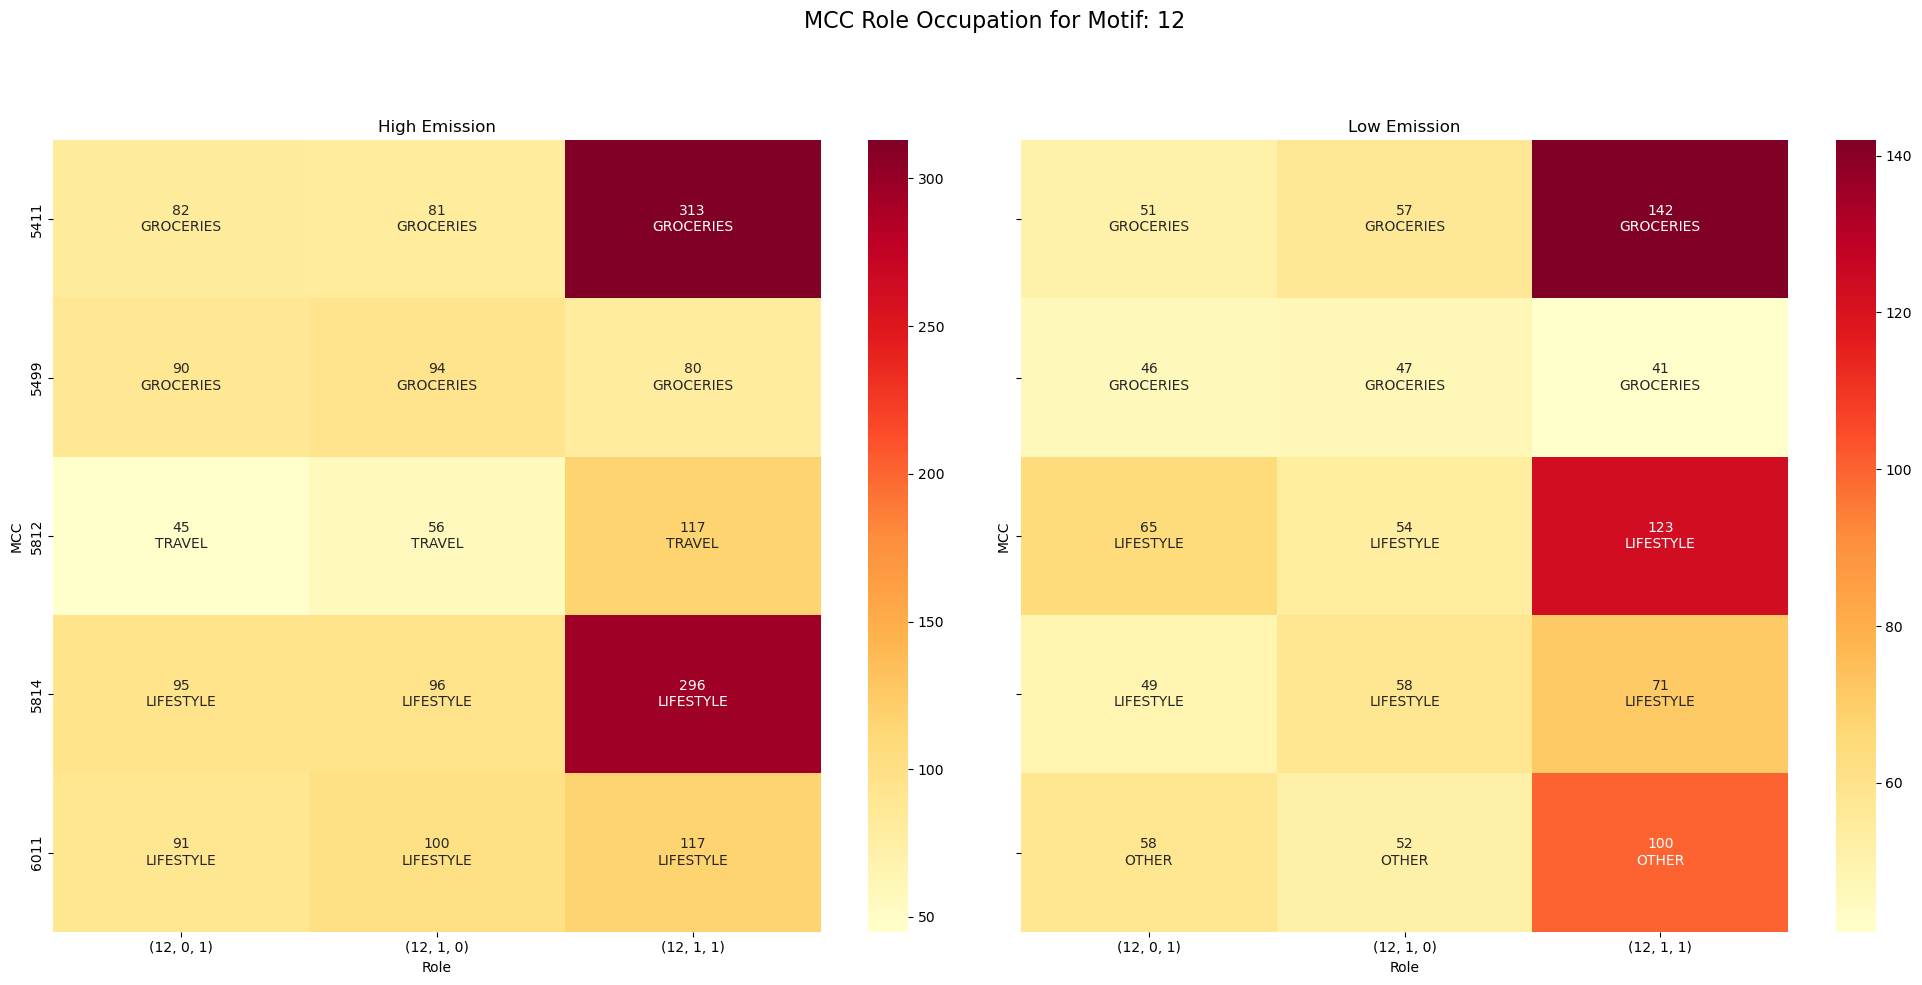

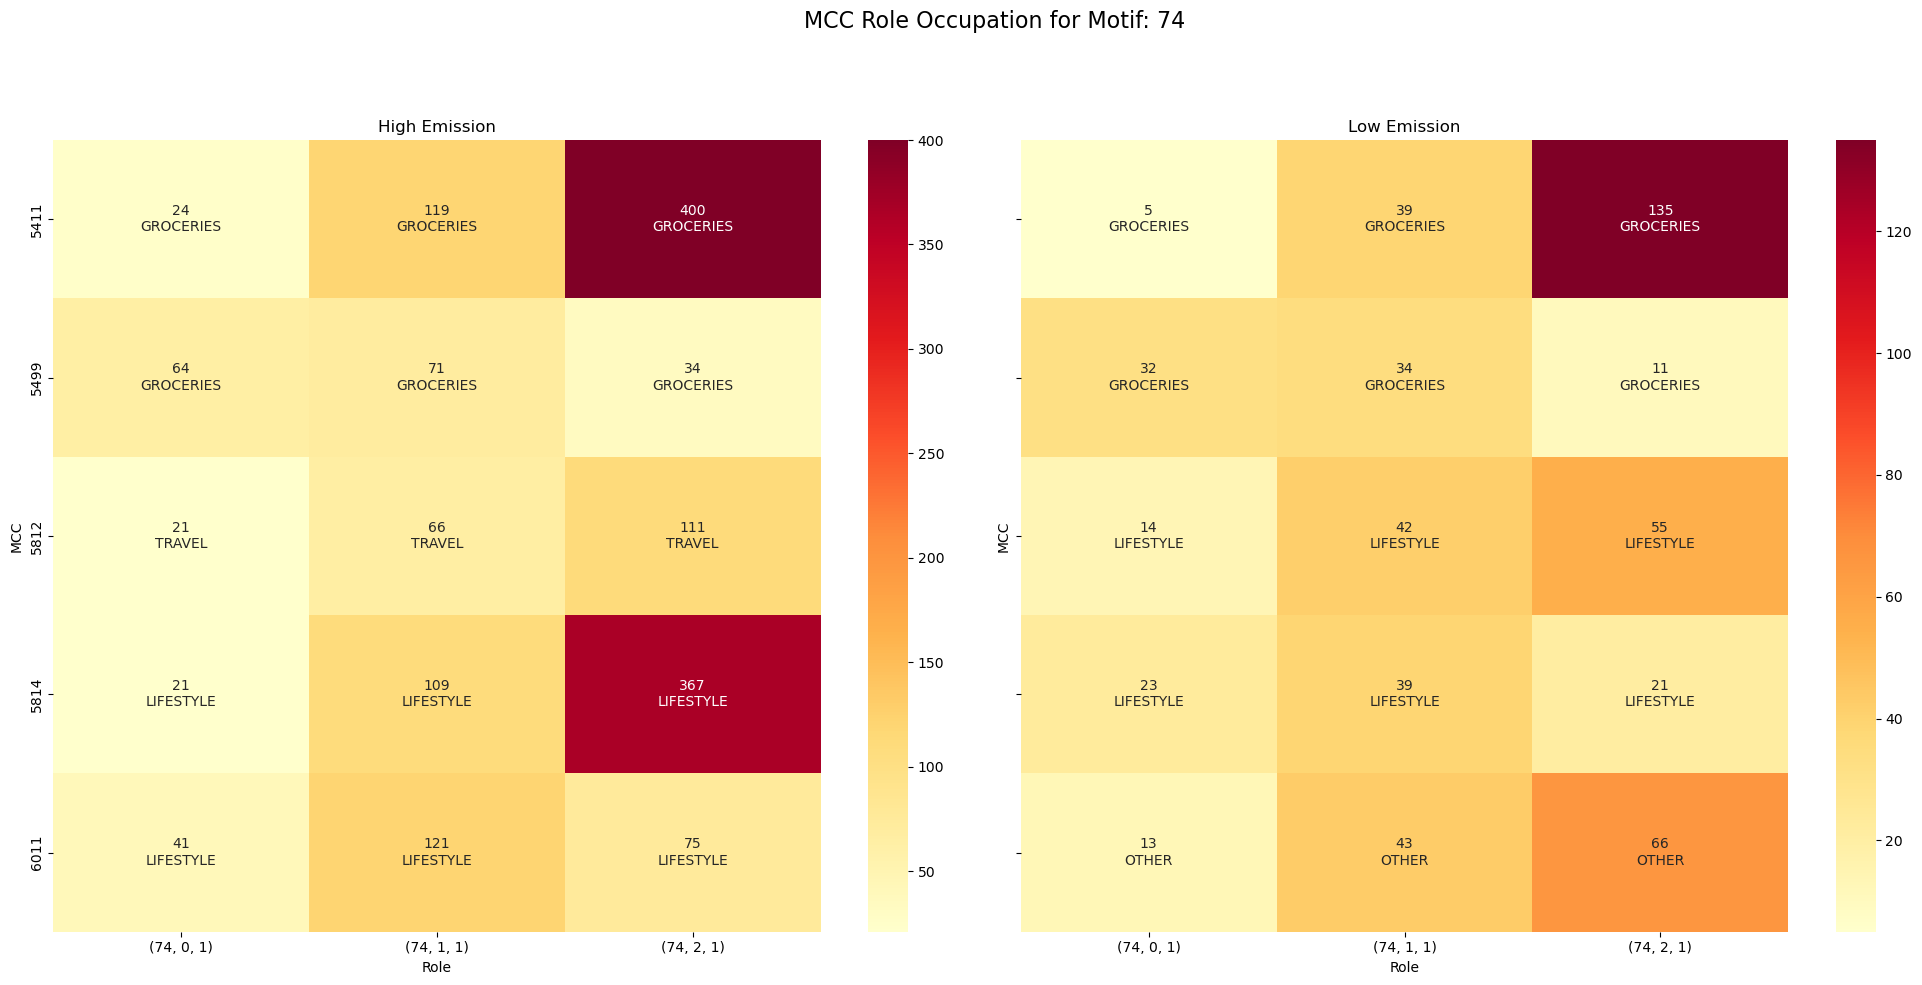

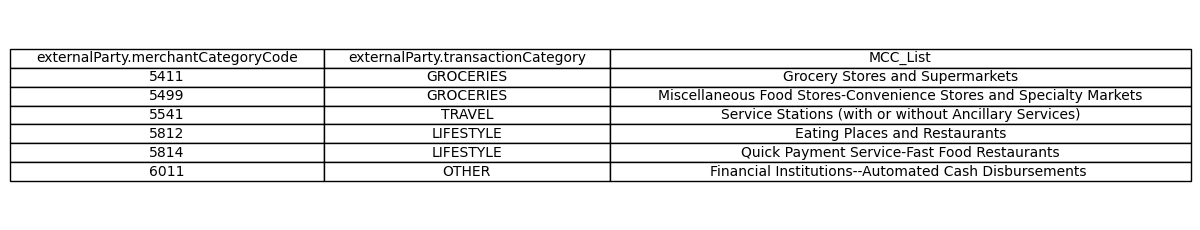

In [421]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def create_mcc_role_occupation_plot(high_data, low_data, mcc_csv_path, top_motifs=3, top_mccs=5):
    def get_top_motifs(data):
        return sorted(data.keys(), key=lambda x: data[x]['total_motif_count'], reverse=True)[:top_motifs]
    
    def get_top_mccs_for_motif(data, motif, top_mccs):
        mcc_counts = Counter(data[motif]['mcc_frequency'])
        return [mcc for mcc, _ in mcc_counts.most_common(top_mccs)]

    def prepare_data(data, motifs, top_mccs_dict):
        result = []
        for motif in motifs:
            top_mccs = top_mccs_dict[motif]
            for mcc in top_mccs:
                if mcc in data[motif]['mcc_roles']:
                    for role, count in data[motif]['mcc_roles'][mcc].items():
                        result.append({
                            'Motif': motif,
                            'MCC': mcc,
                            'Role': role,
                            'Count': count
                        })
        return pd.DataFrame(result)

    # Load MCC details
    mcc_details = pd.read_csv(mcc_csv_path)

    # Ensure unique MCC codes
    mcc_details = mcc_details.drop_duplicates(subset='externalParty.merchantCategoryCode')

    # Create MCC details dictionary
    mcc_details_dict = mcc_details.set_index('externalParty.merchantCategoryCode').to_dict(orient='index')

    # Get top motifs
    high_top_motifs = get_top_motifs(high_data)
    low_top_motifs = get_top_motifs(low_data)
    all_top_motifs = list(set(high_top_motifs + low_top_motifs))

    # Determine top MCCs for each motif in high and low data
    high_top_mccs_dict = {motif: get_top_mccs_for_motif(high_data, motif, top_mccs) for motif in all_top_motifs}
    low_top_mccs_dict = {motif: get_top_mccs_for_motif(low_data, motif, top_mccs) for motif in all_top_motifs}

    # Prepare dataframes for plotting
    high_df = prepare_data(high_data, all_top_motifs, high_top_mccs_dict)
    low_df = prepare_data(low_data, all_top_motifs, low_top_mccs_dict)

    high_df['Group'] = 'High Emission'
    low_df['Group'] = 'Low Emission'
    combined_df = pd.concat([high_df, low_df])

    # Extract unique MCCs used in the plots
    unique_mccs = pd.Series(combined_df['MCC'].unique())

    # Extract and display the MCC details for these unique MCCs
    unique_mcc_details = mcc_details[mcc_details['externalParty.merchantCategoryCode'].isin(unique_mccs)]
    unique_mcc_details = unique_mcc_details[['externalParty.merchantCategoryCode', 'externalParty.transactionCategory', 'MCC_List']].drop_duplicates()

    # Plotting
    for i, motif in enumerate(all_top_motifs):
        motif_data = combined_df[combined_df['Motif'] == motif]
        
        fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex='col', sharey='row')
        fig.suptitle(f'MCC Role Occupation for Motif: {motif}', fontsize=16)

        for j, (group, group_df) in enumerate([('High Emission', high_df), ('Low Emission', low_df)]):
            group_motif_data = motif_data[motif_data['Group'] == group]
            ax_heatmap = axes[j]
            
            if not group_motif_data.empty:
                pivot_data = group_motif_data.pivot(index='MCC', columns='Role', values='Count').fillna(0)
                
                # Create custom annotations
                annotations = pivot_data.copy()
                for mcc in pivot_data.index:
                    mcc_desc = mcc_details_dict.get(mcc, {}).get('externalParty.transactionCategory', 'Unknown')
                    for col in pivot_data.columns:
                        annotations.at[mcc, col] = f'{pivot_data.at[mcc, col]}\n{mcc_desc}'

                sns.heatmap(pivot_data, ax=ax_heatmap, cmap='YlOrRd', annot=annotations, fmt='', cbar=True)
                ax_heatmap.set_title(f'{group}')
            else:
                ax_heatmap.text(0.5, 0.5, 'No Data', ha='center', va='center')
                ax_heatmap.axis('off')
        
        axes[0].set_ylabel('MCC')
        axes[1].set_ylabel('MCC')
        axes[1].set_xlabel('Role')
        
        plt.tight_layout(rect=[0, 0, 1, 0.85])  # Adjust to fit table
        plt.subplots_adjust(top=0.85)
        plt.savefig(f'role_distribution_motif_{motif}.png', format='png', dpi=300, bbox_inches='tight')
        plt.show()

    # Create a single table for all unique MCCs
    fig, ax = plt.subplots(figsize=(12, len(unique_mcc_details) * 0.4))
    ax.axis('off')
    
    table = ax.table(
        cellText=unique_mcc_details.values,
        colLabels=unique_mcc_details.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width([0, 1, 2])

    plt.tight_layout()
    plt.savefig('unique_mcc_details_table.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

# Assuming `aggregated_data_high` and `aggregated_data_low` are already defined
create_mcc_role_occupation_plot(aggregated_data_high, aggregated_data_low, 'MCC.csv')


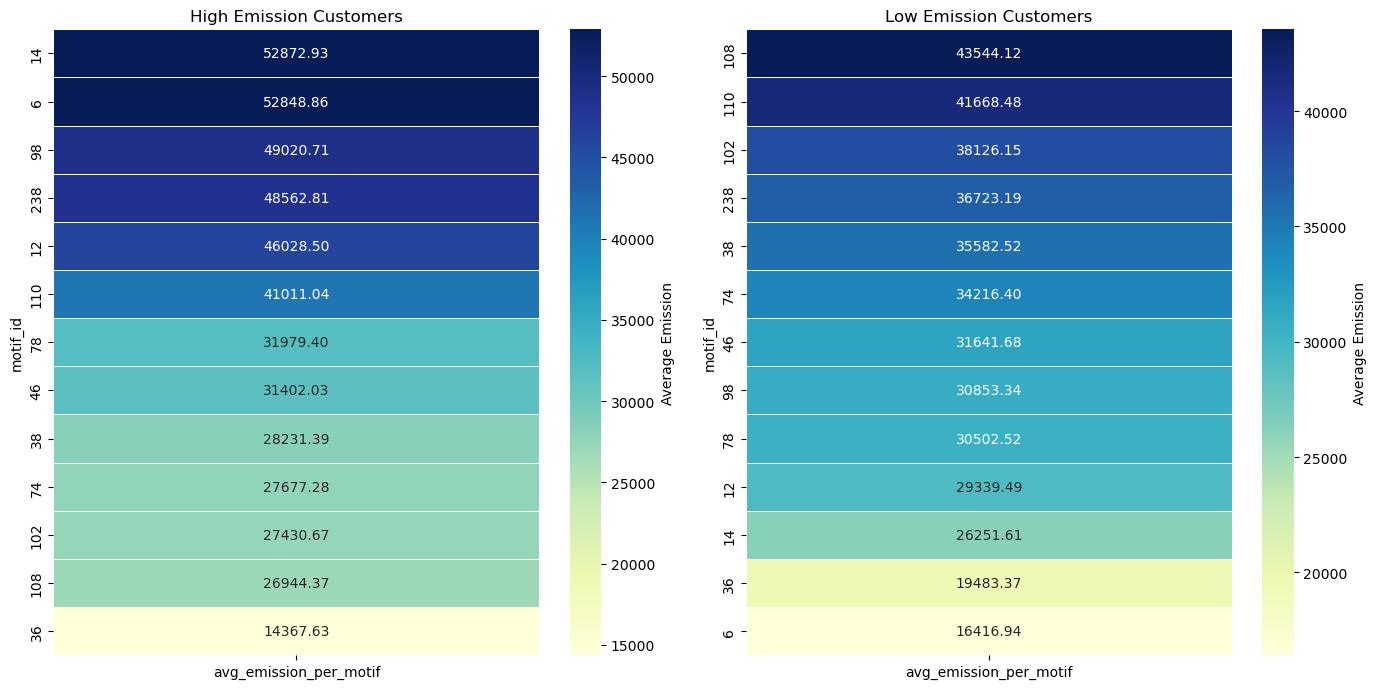

In [3]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the customer data from JSON
with open('motif_results_weight_emission_25.json', 'r') as f:
    all_customers_data = json.load(f)

# Extract motif emissions
emissions_data = []
for customer in all_customers_data:
    emission_category = customer['emission_category']
    motif_emissions = customer.get('motif_emissions', {})
    
    for motif_id, emission in motif_emissions.items():
        emissions_data.append({
            'customer_id': customer['customer_id'],
            'emission_category': emission_category,
            'motif_id': motif_id,
            'total_emission': emission
        })

df_emissions = pd.DataFrame(emissions_data)
df_emissions['log_total_emission'] = np.log1p(df_emissions['total_emission'])

# Extract motif frequencies
frequencies_data = []
for customer in all_customers_data:
    emission_category = customer['emission_category']
    motif_frequencies = customer['results'].get('motifs', {})
    
    for motif_id, freq_data in motif_frequencies.items():
        frequency = freq_data['motif_count']
        frequencies_data.append({
            'customer_id': customer['customer_id'],
            'emission_category': emission_category,
            'motif_id': motif_id,
            'frequency': frequency
        })

df_frequencies = pd.DataFrame(frequencies_data)
df_frequencies = df_frequencies[df_frequencies['frequency'] > 0]

# Merge emissions and frequencies data
df = pd.merge(df_emissions, df_frequencies, on=['customer_id', 'emission_category', 'motif_id'])

# Calculate average emission per motif
df['avg_emission_per_motif'] = df['total_emission'] / df['frequency']

# Separate data for high and low emission categories
df_high = df[df['emission_category'] == 'High Emission']
df_low = df[df['emission_category'] == 'Low Emission']

# Calculate average emission per motif for high and low categories
avg_emission_per_motif_high = df_high.groupby('motif_id')['avg_emission_per_motif'].mean().reset_index()
avg_emission_per_motif_high.columns = ['motif_id', 'avg_emission_per_motif']

avg_emission_per_motif_low = df_low.groupby('motif_id')['avg_emission_per_motif'].mean().reset_index()
avg_emission_per_motif_low.columns = ['motif_id', 'avg_emission_per_motif']

# Prepare data for heatmap
heatmap_data_high = avg_emission_per_motif_high.set_index('motif_id').sort_values('avg_emission_per_motif', ascending=False)
heatmap_data_low = avg_emission_per_motif_low.set_index('motif_id').sort_values('avg_emission_per_motif', ascending=False)

# Plotting the heatmaps
plt.figure(figsize=(14, 7))

# High emission heatmap
plt.subplot(1, 2, 1)
sns.heatmap(heatmap_data_high, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Average Emission'})
plt.title('High Emission Customers')

# Low emission heatmap
plt.subplot(1, 2, 2)
sns.heatmap(heatmap_data_low, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Average Emission'})
plt.title('Low Emission Customers')

plt.tight_layout()
plt.show()
